# Finite Element Analysis of Kirchhoff Thin Plates

This notebook consists of control systems without observer.

In [1]:
import sys, os
import datetime
now = datetime.datetime.now()
sys.path.append("../")

## Saving the outputs in a text file

In [2]:
morph_modes = [3]
directory = "Kirchhoff_Non_Observer_LDE_Mode_" + str(morph_modes) + "_{}_{}_{}".format(now.year, now.month, now.day)
if not os.path.exists(directory):
	os.makedirs(directory)

In [3]:
import numpy as np
import scipy.linalg as sl
import Thin_Plate_Library as TPL
from scipy.integrate import odeint
from control import lqr
from matplotlib import pyplot as plt


In [4]:
solve = np.linalg.solve
rank = np.linalg.matrix_rank
det = np.linalg.det

In [5]:
# plate details
xlength, ylength, thickness = 0.6, 0.2, 0.2e-3
E_p, nu_p, rho = 70e9, 0.3, 2700*thickness
I_p = thickness**3/12

Cmat_p = E_p/(1-nu_p**2)*np.array([[1,nu_p, 0], [nu_p,1,0], [0,0,(1-nu_p)/2]])
Dmat_p = Cmat_p*I_p

In [6]:
# PZT details
pzt_thickness = 0.2e-3
pzt_density = 7750*pzt_thickness
Spzt = sl.block_diag(np.array([[16.4, -5.74, -7.22], [-5.74, 16.4, -7.22], [-7.22, -7.22, 18.8]]), 47.5,47.5,44.3)*1e-12
Ce_pzt = np.linalg.inv(Spzt)[np.ix_([0,1,5],[0,1,5])]
d_mt = np.zeros((6,3))
d_mt[4,0], d_mt[3,1], d_mt[0,2], d_mt[1,2], d_mt[2,2] = 584e-12, 584e-12, -171e-12, -171e-12, 374e-12
d_mt = d_mt[np.ix_([0,1,5],[2])]
e_mt = Ce_pzt.dot(d_mt); e_mt[1:3] = 0
ep0 = 8.854e-12
eps_pzt = 1730*ep0 - d_mt.T.dot(e_mt)

Zpzt = (pzt_thickness*thickness+pzt_thickness**2)/2
I_pzt = (8*pzt_thickness**3+12*pzt_thickness**2*thickness+6*pzt_thickness*thickness**2+thickness**3)/24 - thickness**3/24

Dmat_pzt = Ce_pzt*I_pzt

In [7]:
# FEA details
node_detail = (13, 5)
nodes, nodes_x, nodes_y, total_nodes, elements, elements_x, elements_y, total_elements = TPL.node_element_details(node_detail)

elementSet = np.arange(0, total_elements)
nodeSet = np.arange(0, total_nodes)

elementMatrix = elementSet.reshape(elements).T
nodeMatrix = nodeSet.reshape(nodes).T

print("Node matrix:")
print(nodeMatrix)
print(" ")
print("Element Matrix:")
print(elementMatrix)
print(" ")

Node matrix:
[[ 0  5 10 15 20 25 30 35 40 45 50 55 60]
 [ 1  6 11 16 21 26 31 36 41 46 51 56 61]
 [ 2  7 12 17 22 27 32 37 42 47 52 57 62]
 [ 3  8 13 18 23 28 33 38 43 48 53 58 63]
 [ 4  9 14 19 24 29 34 39 44 49 54 59 64]]
 
Element Matrix:
[[ 0  4  8 12 16 20 24 28 32 36 40 44]
 [ 1  5  9 13 17 21 25 29 33 37 41 45]
 [ 2  6 10 14 18 22 26 30 34 38 42 46]
 [ 3  7 11 15 19 23 27 31 35 39 43 47]]
 


In [8]:
coordinates, X, Y, Xmap, Ymap = TPL.coordinates(xlength, ylength, nodes_x, nodes_y)

# piezoelectric patch details
npzt_elm_x, npzt_elm_y = 2, 2
# npzt_elm_x, npzt_elm_y = 12, 4

nx, ny = int(elements_x/npzt_elm_x), int(elements_y/npzt_elm_y)
total_sensors = nx*ny

element_for_pzt_x, element_for_pzt_y = np.arange(0, elements_x).reshape((nx,npzt_elm_x)), np.arange(0, elements_y).reshape((ny,npzt_elm_y))

In [9]:
print(nx, ny)

6 2


In [10]:
pzt_element_sensors = np.zeros((total_sensors, npzt_elm_x*npzt_elm_y), dtype="int")
n = 0
actuator_address = []
for i in range(ny):
    vertpzt = element_for_pzt_y[i,:]
    for j in range(nx):
        horzpzt = element_for_pzt_x[j,:]
        pzt_elms = elementMatrix[vertpzt,:][:,horzpzt]
        pzt_element_sensors[n,:] = pzt_elms.ravel()
        actuator_address.append([j,i])
        n += 1

pzt_element_actuators = pzt_element_sensors
total_actuators = pzt_element_actuators.shape[0]

print("Actuator Elements:\n")
print(pzt_element_actuators)
print(" ")

print("Sensor Elements:\n")
print(pzt_element_sensors)
print(" ")

Actuator Elements:

[[ 0  4  1  5]
 [ 8 12  9 13]
 [16 20 17 21]
 [24 28 25 29]
 [32 36 33 37]
 [40 44 41 45]
 [ 2  6  3  7]
 [10 14 11 15]
 [18 22 19 23]
 [26 30 27 31]
 [34 38 35 39]
 [42 46 43 47]]
 
Sensor Elements:

[[ 0  4  1  5]
 [ 8 12  9 13]
 [16 20 17 21]
 [24 28 25 29]
 [32 36 33 37]
 [40 44 41 45]
 [ 2  6  3  7]
 [10 14 11 15]
 [18 22 19 23]
 [26 30 27 31]
 [34 38 35 39]
 [42 46 43 47]]
 


In [11]:
connectivity = TPL.connectivity(elements_x, elements_y, nodeMatrix)

dofpn = 3
tdof = total_nodes*dofpn
edof = 4*dofpn

w_total = np.arange(0, tdof, dofpn)
tx_total = np.arange(1, tdof, dofpn)
ty_total = np.arange(2, tdof, dofpn)

w_el = np.arange(0, edof, dofpn)
tx_el = np.arange(1, edof, dofpn)
ty_el = np.arange(2, edof, dofpn)

In [12]:
support_condition="cy"
node_arrest = TPL.node_arresting(coordinates, support_condition)
dof_arrest = TPL.node2dof(node_arrest, dofpn).T.ravel()
non_dof_arrest = np.delete(np.arange(0,tdof), dof_arrest)
k_size = non_dof_arrest.shape[0]

In [13]:
vec = np.array([-np.sqrt(3/7+2/7*np.sqrt(6/5)),-np.sqrt(3/7-2/7*np.sqrt(6/5)),np.sqrt(3/7-2/7*np.sqrt(6/5)),np.sqrt(3/7+2/7*np.sqrt(6/5))])
gpoints = TPL.combvec(vec,vec)
gp = gpoints.shape[0]

weights = np.zeros(gpoints.shape)

for i in range(gp):
	if gpoints[i,0] > 0.5 or gpoints[i,0] < -0.5:
		weights[i,0] = (18-np.sqrt(30))/36
	else:
		weights[i,0] = (18+np.sqrt(30))/36
	if gpoints[i,1] > 0.5 or gpoints[i,1] < -0.5:
		weights[i,1] = (18-np.sqrt(30))/36
	else:
		weights[i,1] = (18+np.sqrt(30))/36

In [14]:
print("Constucting system model matrices...")
Mglobal = np.zeros((tdof, tdof), dtype="float")
Kglobal = np.zeros((tdof, tdof), dtype="float")
Kpglobal = np.zeros((tdof, tdof), dtype="float")
Mpglobal = np.zeros((tdof, tdof), dtype="float")
Kup_a_global = np.zeros((tdof, total_actuators), dtype="float")
Kup_s_global = np.zeros((tdof, total_sensors), dtype="float")
Kpp_a_global = np.zeros((total_actuators, total_actuators), dtype="float")
Kpp_s_global = np.zeros((total_sensors, total_sensors), dtype="float")

Constucting system model matrices...


In [15]:
for element in range(total_elements):
	node_address = connectivity[element, :]
	dof_address = TPL.node2dof(node_address, dofpn).T.ravel()
	element_coordinates = coordinates[node_address, :]
	xx, yy = element_coordinates[:,0], element_coordinates[:,1]
	Me, Ke = 0, 0
	Mep, Kep = 0, 0
	Kup_a, Kup_s = 0, 0
	Kpp_a, Kpp_s = 0, 0
	for i in range(gp):
		gx, gy = gpoints[i,0], gpoints[i,1]
		mapped_coord, Jac = TPL.GaussMapper(gx, gy, element_coordinates)
		J = Jac*weights[i,:].prod()
		x, y = mapped_coord
		Bw, Bm, Bpzt = TPL.DerivMatrices(x, y, xx, yy)
		Me += rho*Bm.T.dot(Bm)*J
		Ke += Bw.T.dot(Dmat_p).dot(Bw)*J
		if np.any(pzt_element_actuators==element):
			Mep += pzt_density*Bm.T.dot(Bm)*J
			Kep += Bw.T.dot(Dmat_pzt).dot(Bw)*J
			Bz = np.array([[1/pzt_thickness]])
			Kup_a += -Zpzt*Bpzt.T.dot(e_mt).dot(Bz)*J
			Kpp_a += Bz.T.dot(eps_pzt).dot(Bz)*J

		if np.any(pzt_element_sensors==element):
			Mep += pzt_density*Bm.T.dot(Bm)*J
			Kep += Bw.T.dot(Dmat_pzt).dot(Bw)*J
			Bz = np.array([[1/pzt_thickness]])
			Kup_s += -Zpzt*Bpzt.T.dot(e_mt).dot(Bz)*J
			Kpp_s += Bz.T.dot(eps_pzt).dot(Bz)*J

	Mglobal[np.ix_(dof_address, dof_address)] += Me
	Kglobal[np.ix_(dof_address, dof_address)] += Ke

	Mpglobal[np.ix_(dof_address, dof_address)] += Mep
	Kpglobal[np.ix_(dof_address, dof_address)] += Kep

	if np.any(pzt_element_actuators==element):
		adr = np.where(pzt_element_actuators==element)[0]
		Kup_a_global[np.ix_(dof_address, adr)] += Kup_a
		Kpp_a_global[np.ix_(adr, adr)] += Kpp_a
	if np.any(pzt_element_sensors==element):
		adr = np.where(pzt_element_sensors==element)[0]
		Kup_s_global[np.ix_(dof_address, adr)] += Kup_s
		Kpp_s_global[np.ix_(adr, adr)] += Kpp_s

In [16]:
Kb = Kglobal[np.ix_(non_dof_arrest, non_dof_arrest)]
Mb = Mglobal[np.ix_(non_dof_arrest, non_dof_arrest)]

Ktotal = Kglobal + Kpglobal
Mtotal = Mglobal + Mpglobal

K = Ktotal[np.ix_(non_dof_arrest, non_dof_arrest)]
M = Mtotal[np.ix_(non_dof_arrest, non_dof_arrest)]

Kup_act = Kup_a_global[np.ix_(non_dof_arrest)]
Kup_sen = Kup_s_global[np.ix_(non_dof_arrest)]

Kpu_act = Kup_act.T
Kpu_sen = Kup_sen.T

In [17]:
# Check symmetry
print("Checking for symmetry...")
print(TPL.check_symmetric(Kb))
print(TPL.check_symmetric(Mb))
print(TPL.check_symmetric(K))
print(TPL.check_symmetric(M))

Checking for symmetry...
True
True
True
True


In [18]:
print("Obtaining the mode shapes and frequencies of the system...")
EigenVectors, EigenValues, _ = TPL.spectrum(Kglobal, Mglobal, non_dof_arrest)
_, _, Frequencies = TPL.spectrum(Ktotal, Mtotal, non_dof_arrest)
# morph_modes = [0,1,2]
mode = 0
for idx, i in enumerate(morph_modes):
    mode += EigenVectors[:, i]

mode1 = TPL.normalize(mode, w_total, 0.2)

morph_2 = [1]

mode = 0
for i in morph_2:
    mode += EigenVectors[:, i]

mode2 = TPL.normalize(mode, w_total, 0.2)

init_shape = TPL.vec2shape(mode1, w_total, nodes)
print(init_shape.shape)
print(Xmap.shape)

# file_name = directory + "/shapes"
# print(file_name)
# storage = {"Xmap":Xmap, "Ymap":Ymap, "Z":init_shape, "mode":morph_modes}
# TPL.savemat(file_name, storage)

Obtaining the mode shapes and frequencies of the system...
(5, 13)
(5, 13)


In [19]:
cdr = 2.0/100
w1 = Frequencies[0]*2*np.pi
w2 = Frequencies[1]*2*np.pi
damping_coefs = solve(np.array([[0.5/w1, 0.5*w1], [0.5/w2, 0.5*w2]]), np.vstack([cdr, cdr]))
print(Frequencies[0])
print(Frequencies[1])

0.2568446991897502
0.30907345096286204


In [20]:
print("Preparing initial conditions...")
x_reference = mode1[non_dof_arrest]
xd_referecene = np.zeros(x_reference.shape)
X_reference = np.hstack([x_reference, xd_referecene])
X_initial = np.zeros(X_reference.shape)

Preparing initial conditions...


In [21]:
print("Constructing state space model...")
Os = np.zeros((k_size, k_size))
Is = np.eye(k_size, k_size)
C = damping_coefs[0]*M + damping_coefs[1]*K
# C = 0*M + 0*K
# Piezoelectric forces
S = -solve(Kpp_s_global, Kpu_sen)
B = -solve(M, Kup_act)

# State Transition matrix
A21 = -solve(M, K)
A22 = -solve(M, C)

Asys = np.vstack([np.hstack([Os, Is]), np.hstack([A21, A22])])
Bsys = np.vstack([np.zeros((k_size, total_actuators)), B])
Csys = np.hstack([S, np.zeros((total_sensors, k_size))])

Constructing state space model...


In [22]:
# Controller implementation
# LQR controller
_, Klqr = TPL.lqr_controller(Asys, Bsys)
_, Kodi, _ = TPL.ODI_controller_v1(A21, A22, B, S, 100, 100)
# W = 50*np.eye(2*k_size, 2*k_size)
# K = W-Asys
# _, Kodi, _ = TPL.ODI_controller_v2(Asys, Bsys, K)
Alqr = Asys - Bsys.dot(Klqr)
Aodi = Asys - Bsys.dot(Kodi)

In [23]:
# Static control inputs
y_reference = Csys.dot(X_reference)
Mx, Mu = TPL.static_input(Asys, Bsys, Csys)

mat = solve(Csys.dot(solve(-Asys, Bsys)), np.eye(total_sensors))
mat_o = solve(Csys.dot(solve(-Aodi, Bsys)), np.eye(total_sensors))


Force_u = Bsys.dot(mat)
Force_lqr = Bsys.dot(Mu + Klqr.dot(Mx))
Force_odi = Bsys.dot(mat_o)

In [24]:
t0 = 0.0
h = 0.01
Tf = 20.0
tspan = np.arange(t0, Tf, h)
n = tspan.shape[0]

In [25]:
def reference_states(t):
    return X_reference

def percentage(t):
    print("Completed... {0:.0f} %".format(t/Tf*100), end='\r', flush=True)
    
def reference(t):
    return y_reference
    
def system(X, t):
    percentage(t)
    return Asys.dot(X) + Force_u.dot(reference(t))

def lqr_system(X, t):
    percentage(t)
    return Alqr.dot(X) + Force_lqr.dot(reference(t))

def odi_system(X, t):
    percentage(t)
    return Aodi.dot(X) + Force_odi.dot(reference(t))

In [26]:
print("Solving time integration problem...")
print("Uncontrolled system...")
uncontroller_trajectory = odeint(system, X_initial, tspan)
# print("LQR controlled system...")
# lqr_trajectory = odeint(lqr_system, X_initial, tspan)
print("ODI controlled system...")
odi_trajectory = odeint(odi_system, X_initial, tspan)

Solving time integration problem...
Uncontrolled system...


In [27]:
displacements_u, velocities_u = TPL.splitting_reconstruction(uncontroller_trajectory, non_dof_arrest, tdof, k_size)
# displacements_lqr, velocities_lqr = TPL.splitting_reconstruction(lqr_trajectory, non_dof_arrest, tdof, k_size)
displacements_odi, velocities_odi = TPL.splitting_reconstruction(odi_trajectory, non_dof_arrest, tdof, k_size)

In [28]:
norm_D_u, norm_V_u = TPL.norms(displacements_u), TPL.norms(velocities_u)
# norm_D_lqr, norm_V_lqr = TPL.norms(displacements_lqr), TPL.norms(velocities_lqr)
norm_D_odi, norm_V_odi = TPL.norms(displacements_odi), TPL.norms(velocities_odi)

In [29]:
static_u = np.asarray([mat.dot(reference(t)) for t in tspan])
# control_lqr = lqr_trajectory.dot(-Klqr.T) + np.asarray([(Mu+Klqr.dot(Mx)).dot(reference(t)) for t in tspan])
control_odi = odi_trajectory.dot(-Kodi.T) + np.asarray([mat_o.dot(reference(t)) for t in tspan])

In [30]:
print(static_u[-1])
# print(control_lqr[-1])
print(control_odi[-1])

[ 1.30703169e+04  1.38156372e+03  3.92192326e+03 -1.39265345e+04
  1.60965528e+03 -5.32494180e+03  1.42889187e+04  1.33831340e+01
  2.28619375e+03 -1.31445578e+04 -2.19534327e+03 -1.69754365e+03]
[ 1.30461035e+04  1.37218597e+03  3.92192596e+03 -1.39040303e+04
  1.62518666e+03 -5.32859582e+03  1.42689165e+04  1.02394763e+01
  2.28694950e+03 -1.31246055e+04 -2.18954411e+03 -1.70110387e+03]


In [31]:
desired_state = np.asarray([reference_states(t) for t in tspan])
desired_state_norm = TPL.norms(desired_state)
print(desired_state_norm[-1])

11.381954721860927


In [32]:
sensor_output = odi_trajectory.dot(Csys.T)
sensor_out_static = uncontroller_trajectory.dot(Csys.T)

In [33]:
# plot file names
displacement_fname = directory + "/displacememt.png"
velocity_fname = directory + "/velocity.png"
control_fname = directory + "/control.png"
sensor_fname = directory + "/sensor.png"

<IPython.core.display.Javascript object>


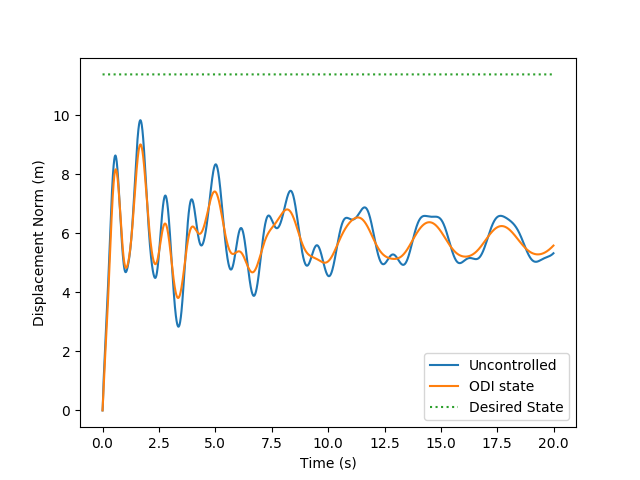

In [34]:
%matplotlib notebook
plt.figure()
plt.plot(tspan, norm_D_u, label="Uncontrolled")
# plt.plot(tspan, norm_D_lqr, label="LQR state")
plt.plot(tspan, norm_D_odi, label="ODI state")
plt.plot(tspan, desired_state_norm, ':', label="Desired State")
plt.xlabel("Time (s)")
plt.ylabel("Displacement Norm (m)")
plt.legend()
plt.show()
plt.savefig(displacement_fname)

<IPython.core.display.Javascript object>


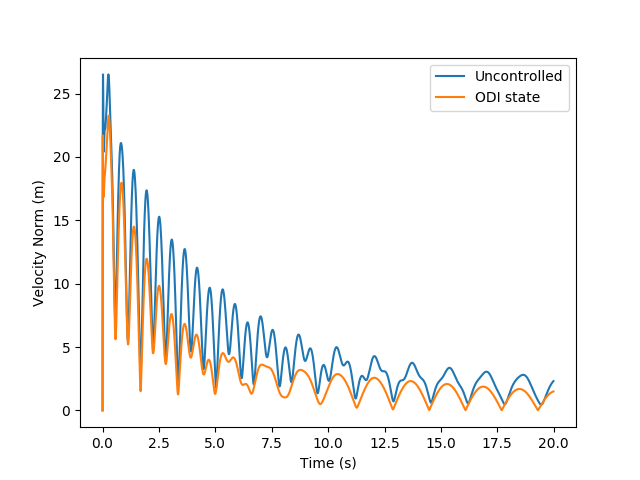

In [35]:
plt.figure()
plt.plot(tspan, norm_V_u, label="Uncontrolled")
# plt.plot(tspan, norm_V_lqr, label="LQR state")
plt.plot(tspan, norm_V_odi, label="ODI state")
plt.xlabel("Time (s)")
plt.ylabel("Velocity Norm (m)")
plt.legend()
plt.show()
plt.savefig(velocity_fname)

<IPython.core.display.Javascript object>


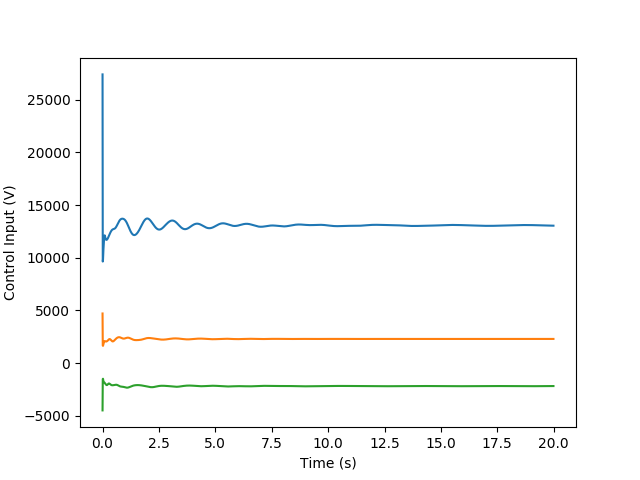

In [36]:
# plt.figure()
# plt.plot(tspan, control_lqr)
# plt.plot(tspan, static_u, ':')
# plt.show()
actuator_info = [[0,0], [2,1], [4,1]]
lst = [actuator_address.index(i) for i in actuator_info]

plt.figure()
plt.plot(tspan, control_odi[:, lst])
# plt.plot(tspan, static_u[:,lst], ':')
plt.xlabel("Time (s)")
plt.ylabel("Control Input (V)")
plt.show()
plt.savefig(control_fname)

<IPython.core.display.Javascript object>


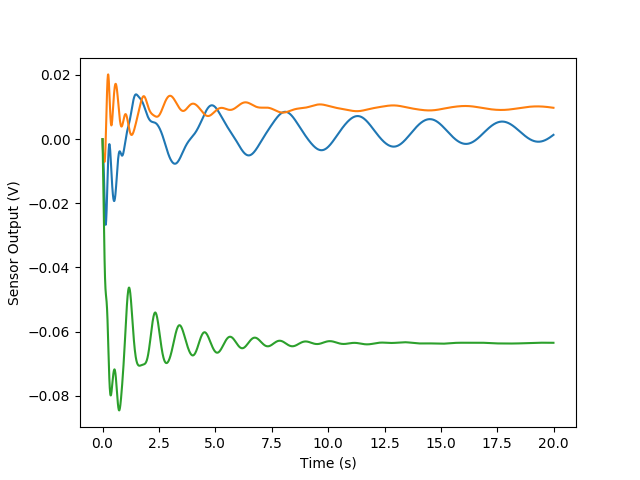

In [37]:
# plt.figure()
# plt.plot(tspan, control_lqr)
# plt.plot(tspan, static_u, ':')
# plt.show()

plt.figure()
plt.plot(tspan, sensor_output[:, lst])
# plt.plot(tspan, sensor_out_static[:,lst], ':')
plt.xlabel("Time (s)")
plt.ylabel("Sensor Output (V)")
plt.show()
plt.savefig(sensor_fname)

In [38]:
# # sys.stdout.close()

# # storing the data
# storage = {"displacements_u":displacements_u, "velocities_u": velocities_u,
# 			"displacements_lqr": displacements_lqr, "velocities_lqr": velocities_lqr,
# 			"time": tspan, "norm_D_u": norm_D_u, "norm_V_u":norm_V_u, "norm_D_lqr":norm_D_lqr,
# 			"norm_V_lqr":norm_V_lqr, "Frequencies":Frequencies, "Xmap":Xmap,
# 			"Ymap":Ymap}

# directory = "Data"
# if not os.path.exists(directory):
# 	os.makedirs(directory)
# storage_file = "{}_{}_{}_{}_{}_FEA_plate_storage".format(controller, now.year, now.month, now.day, now.hour)
# filename = os.path.join(directory, storage_file)
# # TPL.savemat(filename, storage)